A new disease hase been discovered (we will refer to it as Disease P) which is thought to closely resemble anemia. Notably it is believed to be similar in that there is thought to be a number of variants of Disease P, each of which will require its own treatment.

As a pharmaceutical company, we want to create treatments for all variants. To most efficiently use our resources, we want to identify the different groups (clusters) of Disease P so that we can stand-up research teams for each to tackle the solutions.

Given its simiarity to anemia, we will explore if we believe that clustering models built on anemia data can be used to cluster the same feature set for Disease P.

In [45]:
#install required packages
!pip install umap-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.datasets import fetch_openml
import umap
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn import metrics
from scipy.stats import mstats
import seaborn as sns



The dataset was located on Kaggle at https://www.kaggle.com/datasets/ehababoelnaga/anemia-types-classification.

It contains CBC <B>labeled</B> data, with the diagnosis of Anemia type. The data was collected and diagnosed manually.

In [46]:
df=pd.read_csv("https://www.dropbox.com/scl/fi/pognta2hd2sz9whorbeb6/diagnosed_cbc_data_v4.csv?rlkey=w9a6wnh875vcs3rxymirvyedc&st=1psw9lv6&dl=1")

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1281 entries, 0 to 1280
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   WBC        1281 non-null   float64
 1   LYMp       1281 non-null   float64
 2   NEUTp      1281 non-null   float64
 3   LYMn       1281 non-null   float64
 4   NEUTn      1281 non-null   float64
 5   RBC        1281 non-null   float64
 6   HGB        1281 non-null   float64
 7   HCT        1281 non-null   float64
 8   MCV        1281 non-null   float64
 9   MCH        1281 non-null   float64
 10  MCHC       1281 non-null   float64
 11  PLT        1281 non-null   float64
 12  PDW        1281 non-null   float64
 13  PCT        1281 non-null   float64
 14  Diagnosis  1281 non-null   object 
dtypes: float64(14), object(1)
memory usage: 150.2+ KB


In [48]:
df.head()

,WBC,LYMp,NEUTp,LYMn,NEUTn,RBC,HGB,HCT,MCV,MCH,MCHC,PLT,PDW,PCT,Diagnosis
0,10.0,43.2,50.1,4.3,5.0,2.77,7.3,24.2,87.7,26.3,30.1,189.0,12.5,0.17,Normocytic hypochromic anemia
1,10.0,42.4,52.3,4.2,5.3,2.84,7.3,25.0,88.2,25.7,20.2,180.0,12.5,0.16,Normocytic hypochromic anemia
2,7.2,30.7,60.7,2.2,4.4,3.97,9.0,30.5,77.0,22.6,29.5,148.0,14.3,0.14,Iron deficiency anemia
3,6.0,30.2,63.5,1.8,3.8,4.22,3.8,32.8,77.9,23.2,29.8,143.0,11.3,0.12,Iron deficiency anemia
4,4.2,39.1,53.7,1.6,2.3,3.93,0.4,316.0,80.6,23.9,29.7,236.0,12.8,0.22,Normocytic hypochromic anemia


The daya looks to be generally clean (e.g. no missing values according to the listed info above), but let's check a few other things to make sure it looks good.

In [49]:
# Check for any duplicate rows in the DataFrame
duplicate_rows = df[df.duplicated()]

# Get the count of duplicate rows
num_duplicates = duplicate_rows.shape[0]
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 49


In [50]:
#drop duplicates
df.drop_duplicates(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1232 entries, 0 to 1280
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   WBC        1232 non-null   float64
 1   LYMp       1232 non-null   float64
 2   NEUTp      1232 non-null   float64
 3   LYMn       1232 non-null   float64
 4   NEUTn      1232 non-null   float64
 5   RBC        1232 non-null   float64
 6   HGB        1232 non-null   float64
 7   HCT        1232 non-null   float64
 8   MCV        1232 non-null   float64
 9   MCH        1232 non-null   float64
 10  MCHC       1232 non-null   float64
 11  PLT        1232 non-null   float64
 12  PDW        1232 non-null   float64
 13  PCT        1232 non-null   float64
 14  Diagnosis  1232 non-null   object 
dtypes: float64(14), object(1)
memory usage: 154.0+ KB


In [51]:
#check fo rany rows where all variables are zero
all_zero_rows = df[(df == 0).all(axis=1)]

# Get the count of rows where all values are zero
num_all_zero_rows = all_zero_rows.shape[0]
print(f"Number of rows where all values are zero: {num_all_zero_rows}")

Number of rows where all values are zero: 0


While the dataset that we will use contains the true anemia diagnosis (below), our focus is on develping a model which will present strong clustering, which can be used against Disease P data, but not which necessarily strongly aligns to the current clusters (diagnosis).

Therefore, while we will use ARI as a guide, ultimately silhouette and clusters number will be more important metrics for us.

In [52]:
#view the current labels and counts
df["Diagnosis"].value_counts()

,count
Diagnosis,
Healthy,323
Normocytic hypochromic anemia,271
Normocytic normochromic anemia,255
Iron deficiency anemia,184
Thrombocytopenia,72
Other microcytic anemia,56
Leukemia,44
Macrocytic anemia,16
Leukemia with thrombocytopenia,11


In [53]:
# Generate mapping from current target names to single characters to make visualization easier
unique_categories = df['Diagnosis'].unique()
character_map = {unique_categories[i]: chr(65 + i) for i in range(len(unique_categories))}

# Map the categories in the DataFrame
df['Diagnosis Code'] = df['Diagnosis'].map(character_map)

df["Diagnosis Code"].value_counts()

,count
Diagnosis Code,
E,323
A,271
G,255
B,184
F,72
C,56
D,44
I,16
H,11


Outliers can really affect our model, we will therefore look to see which features may have out of bounds values and will use winsorization to compress them.

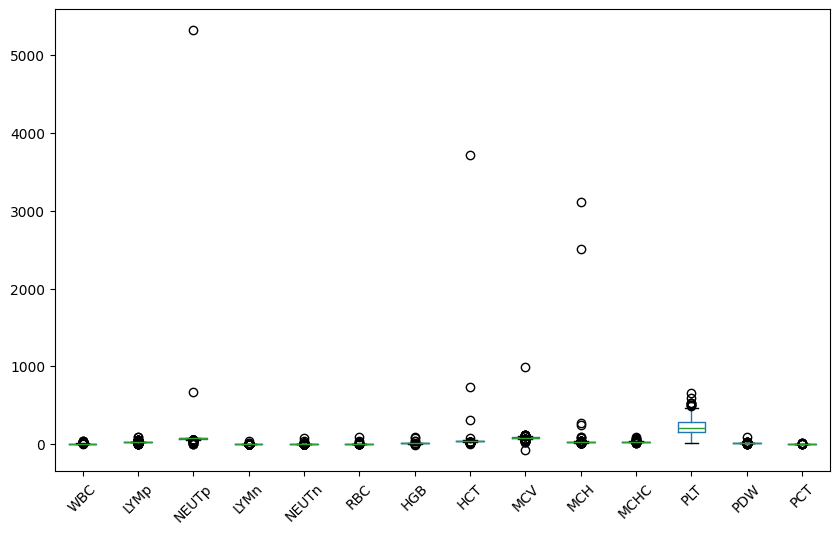

In [54]:
numeric_df = df.select_dtypes(include='number')
plt.figure(figsize=(10, 6))
numeric_df.boxplot()
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

In [55]:
#winsorizaing columns with notable outliers
columns=['NEUTp','HCT','MCV','MCH','PLT']
lower_limit, upper_limit = 0.05, 0.95
for col in columns:
    df[col]=mstats.winsorize(df[col],limits=(lower_limit, upper_limit))

Given that high-dimensionality can really make clustering difficult, we will look to further reduce our feature set by elimating any fields with are significantly correlated.

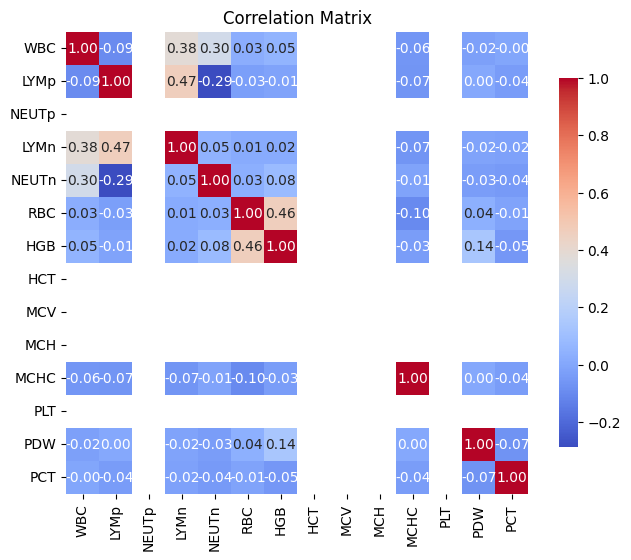

In [56]:
correlation_matrix = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix")
plt.show()

In [57]:
#dropping LYMp and keeping LYMn
df.drop(columns=["LYMp"],inplace=True)

Now we will create the feature and target sets. For the feature sets, we will aplly standardization to the data (putting it all on the same scale) as clustering algorithms are very sensitive to this.

In [58]:
#set up the features and target
X=df.drop(columns=["Diagnosis",'Diagnosis Code'])
y=df["Diagnosis Code"]

#standardizing the features
scaler=StandardScaler()
X_std=scaler.fit_transform(X)

print(X_std.shape, y.shape)

(1232, 13) (1232,)


We have 13 features with 1281 observations

For dimensionality reduction to support visual inspection, we will go with T-SNE and UMAP. They are powerful modern approachs which will not require linearty.

In [59]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

umap_results = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation').fit_transform(X_std)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [60]:
#map the anemia categories to colors usable by matplotlib
color_map = {
    'A': 'r',
    'B': 'b',
    'C': 'g',
    'D': 'c',
    'E': 'm',
    'F': 'y',
    'G': 'k',
    'H': 'orange',
    'I': 'purple'
}

First we will look at the T-SNE results

In [61]:
plt.figure(figsize=(8,4))
for i in range(tsne_results.shape[0]):
    color = color_map[y.iloc[i]]
    plt.text(tsne_results[i, 0], tsne_results[i, 1], str(y.iloc[i]),
             color=color,
             fontdict={'weight': 'bold', 'size': 50})

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

We can see some obvsious clusters (e.g. the purple in the upper right), but in general the data is not obviosuly separable.

Let's take a look at the UMAP visual.

In [62]:
plt.figure(figsize=(8,4))
for i in range(umap_results.shape[0]):
    color = color_map[y.iloc[i]]
    plt.text(umap_results[i, 0], umap_results[i, 1], str(y.iloc[i]),
             color=color,
             fontdict={'weight': 'bold', 'size': 50})

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

There is a little better separation, but it is not as clear as hoped.

Next we will try a couple of clustering algorithms and compare them using their ARI and Silhouette scores. I will be using Hierarchical and DBSCAN approaches. K-Means is not likely to do well here given then non-spherical and spread out nature of the clusters.

We will take advantage of the fact that we know that we have 9 true categories in the set-up of these classfiiers.

In [63]:
#create heirarchical clusters
agg_cluster = AgglomerativeClustering(linkage="ward", n_clusters=9)
clusters = agg_cluster.fit_predict(X_std)

In [64]:
print(f"ARI score: {metrics.adjusted_rand_score(y, clusters)}")
print(f"Silhouette score: {metrics.silhouette_score(X_std, clusters, metric='euclidean')}")

ARI score: 0.04722791829674811
Silhouette score: 0.41739623808674553


The ARI score is quite poor, only slightly better than random. **The Silhouette score however is quite positive**, and as indicated earlier, this is a more key metric for our case.

We will now try DBScan below.

In [65]:
min_list=range(1,20)

#try different min_samples values
for i in min_list:
  dbs_cluster = DBSCAN(eps=1, min_samples=i, metric="euclidean")
  clusters = dbs_cluster.fit_predict(X_std)
  print(f"For a min_samples of {i} we get {len(np.unique(clusters))} clusters")

For a min_samples of 1 we get 77 clusters
For a min_samples of 2 we get 6 clusters
For a min_samples of 3 we get 3 clusters
For a min_samples of 4 we get 3 clusters
For a min_samples of 5 we get 3 clusters
For a min_samples of 6 we get 3 clusters
For a min_samples of 7 we get 3 clusters
For a min_samples of 8 we get 3 clusters
For a min_samples of 9 we get 3 clusters
For a min_samples of 10 we get 3 clusters
For a min_samples of 11 we get 2 clusters
For a min_samples of 12 we get 2 clusters
For a min_samples of 13 we get 2 clusters
For a min_samples of 14 we get 2 clusters
For a min_samples of 15 we get 2 clusters
For a min_samples of 16 we get 2 clusters
For a min_samples of 17 we get 2 clusters
For a min_samples of 18 we get 2 clusters
For a min_samples of 19 we get 2 clusters


In [66]:
#create dbscan clusters with the optimal min_samples value
dbs_cluster = DBSCAN(eps=1, min_samples=2, metric="euclidean")
clusters = dbs_cluster.fit_predict(X_std)

In [67]:
print(f"ARI score: {metrics.adjusted_rand_score(y, clusters)}")
print(f"Silhouette score: {metrics.silhouette_score(X_std, clusters, metric='euclidean')}")

ARI score: 0.016313785360061075
Silhouette score: 0.2679882260335187


Neither of these scores is very positive for this approach.

Since neither algorithm gave great results, we will try a third: Gaussian Mixture.

In [68]:
from sklearn.mixture import GaussianMixture

In [69]:
gmm_cluster = GaussianMixture(n_components=2, random_state=3)

clusters = gmm_cluster.fit_predict(X_std)

print(f"ARI score: {metrics.adjusted_rand_score(y, clusters)}")
print(f"Silhouette score: {metrics.silhouette_score(X_std, clusters, metric='euclidean')}")

ARI score: 0.0010356836799940482
Silhouette score: 0.9105673230926942


The Silhouette score is extremely good - suspiciously so...

In [70]:
print(f"Unique clusters predicted: {len(np.unique(clusters))}")

Unique clusters predicted: 2


We can see that the reason for this high Silhouette score is that it is has simply divided the data into two sets. Given that we know there are actually 9, we know this is bad result, which is furthered confirmed by the ARI score.

Let's see if some further feature reduction may lead to improvement from our best approach so far (heirarchical clustering). Our approach will be to train a simple decision tree, observe the feature used, and drop some seemingly unimportant ones.

In [71]:
from sklearn.tree import DecisionTreeClassifier

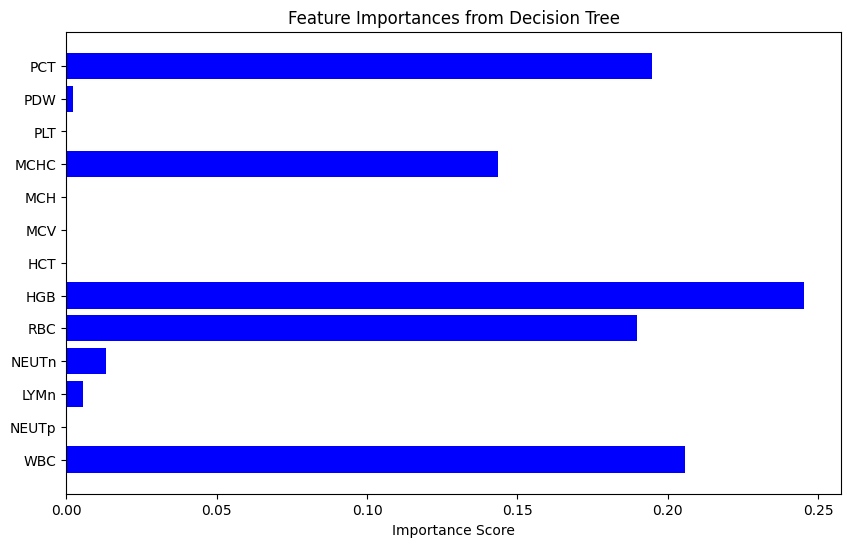

In [72]:
#train a tree with a max depth of 5 and with consideration of our imblance in target values
clf = DecisionTreeClassifier(random_state=11,class_weight='balanced',max_depth=5)
clf.fit(X, y)

importances = clf.feature_importances_

#print the feature importances
plt.figure(figsize=(10, 6))
indices = np.arange(len(importances))
plt.barh(indices, importances, color='blue')
plt.yticks(indices, X.columns)
plt.xlabel('Importance Score')
plt.title('Feature Importances from Decision Tree')
plt.show()

In [73]:
#drop the PLT feature to see if that gives us any improvement
X=df.drop(columns=["Diagnosis","Diagnosis Code","PLT"])

scaler=StandardScaler()
X_std=scaler.fit_transform(X)

In [74]:
#retrain our heirarchical classifier and see the new scores
agg_cluster = AgglomerativeClustering(linkage="average",n_clusters=9)
clusters = agg_cluster.fit_predict(X_std)

print(f"ARI score: {metrics.adjusted_rand_score(y, clusters)}")
print(f"Silhouette score: {metrics.silhouette_score(X_std, clusters, metric='euclidean')}")

ARI score: 0.0038495771657553086
Silhouette score: 0.8484294896729914


Let's try a little hyperparameter exploration...

In [75]:
from sklearn.model_selection import ParameterGrid

In [76]:
#parameters to iterate over
param_grid = {
    'n_clusters': [8,9,10],
    'metric': ['euclidean'],
    'linkage': ['ward', 'complete', 'average']
}

best_params = None
best_ari = -1
best_silhouette = -1
best_score_combination = None

# Loop over each combination of parameters
for params in ParameterGrid(param_grid):
    agg_cluster = AgglomerativeClustering(**params)
    labels = agg_cluster.fit_predict(X_std)
    ari = metrics.adjusted_rand_score(y, labels)
    silhouette = metrics.silhouette_score(X_std, labels)
    if silhouette > best_silhouette or ari > best_ari:
        best_params = params
        best_ari = ari
        best_silhouette = silhouette
        best_score_combination = (ari, silhouette)

# Output the best set of parameters and corresponding scores
print("Best Parameters:", best_params)
print("Best Adjusted Rand Index (ARI):", best_ari)
print("Best Silhouette Score:", best_silhouette)

Best Parameters: {'linkage': 'average', 'metric': 'euclidean', 'n_clusters': 10}
Best Adjusted Rand Index (ARI): 0.003895968631034692
Best Silhouette Score: 0.795680571555473


<B>Our best Silhouette score</B > (linkage="average",n_clusters=9) <B>has increased by 20+%.</B> This is encouraging.

It looks like going down a feature optimization path would be wise here. We could consider options like removing features with low variance, low correlation with the target, training a logistic regression model and removing features with low absolute values, etc.

Again focusing on the Silhouette score, we see that this approach does appear to create tight clustering with a cluster number of 9. However, the low ARi score is still very concerning. While continuing to tweak the feature set is a good next step and should be pursued, there is evidence here to suggest that the current dataset does not capture the variance in the target variable sufficiently.
